In [64]:
import nengo
import numpy as np
import matplotlib.pyplot as plt
from nengo.utils.numpy import rmse
%matplotlib inline

from constants import *

In [39]:
period = 0.5
sin_per = (2 * np.pi * 10)


def sin_targ(t):
    return np.sin(sin_per*t)

def cos_targ(t):
    return 0.5*np.cos(cos_per*t)

targ_funcs = [sin_targ, cos_targ]

def bump_func(t):
    return 1 if t < 0.1 else 0

In [40]:
run_num = 10

In [47]:
from direct_dmp_net2 import get_direct_decoders

def run_dd(target_func, seed=0):
    with nengo.Network() as dd_model:
        osc = nengo.Network()
        osc.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
        osc.config[nengo.Ensemble].seed = seed
        nengo.networks.Oscillator(0.1, 2*np.pi/period, 300, net=osc)

        output = nengo.Node(size_in=1)

        dd = get_direct_decoders(target_func, period, osc, bump_func)

        bump = nengo.Node(bump_func)
        nengo.Connection(bump, osc.ensemble[0])

        nengo.Connection(osc.ensemble.neurons, output, transform=dd.T)

        p_out = nengo.Probe(output)
        
    with nengo.Simulator(dd_model) as dd_sim:
        dd_sim.run(4*period)
        
    return dd_sim.data[p_out][int(2*period/dt):]

In [48]:
dd_res = []

for targ in targ_funcs:
    for n in range(run_num):
        dd_res.append(run_dd(targ, seed=n))

Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:

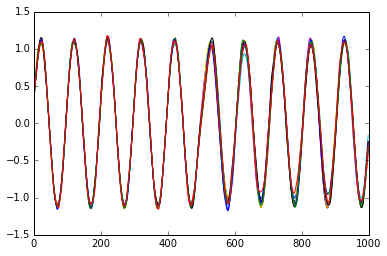

In [49]:
res = np.array(dd_res).reshape((run_num, -1)).T
plt.plot(res)

In [51]:
res.shape

(1000, 10)

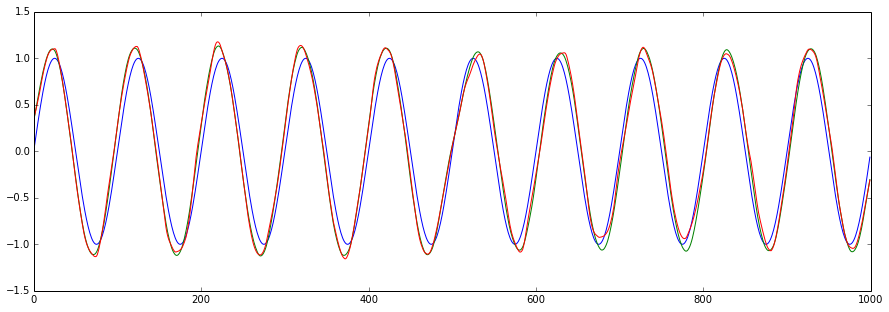

In [70]:
plt.figure(figsize=(15,5))
plt.plot(target_func(np.arange(0, res.shape[0]*dt, dt)))
plt.plot(np.mean(res, axis=1))
plt.plot(res[:, 9])
# okay, so clearly there's no such thing as a meaningful phase shift here

In [68]:
targ_res = target_func(np.arange(0, res.shape[0]*dt, dt))
rmse_vals = np.zeros(run_num)
for i in range(run_num):
    rmse_vals[i] = rmse(targ_res[i], res)

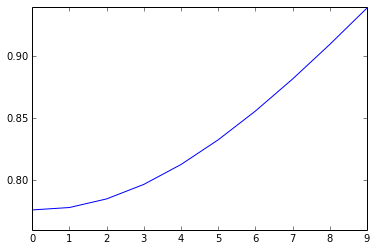

In [71]:
plt.plot(rmse_vals)

In [73]:
targ_res = target_func(np.arange(0, res.shape[0]*dt, dt))
np.savez("results/dd_res_sin", truth=targ_res, res=res)